In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP, GraphPPL, RxInfer, Distributions, LinearAlgebra, Random, Rocket,Plots,StableRNGs
using Flux,Zygote
using BenchmarkTools
import KernelFunctions: Matern52Kernel, with_lengthscale

In [3]:
Random.seed!(3)
xmin, xmax = -3, 3  # Bounds of the data
N = 100# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
xtest = sort(vcat(xtest,xtrain))
precision = 50
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

k_func = (θ) -> with_lengthscale(Matern52Kernel(),θ) 
meanfunc   = (x) -> 0.0;
θ_init = 1.7 #our initial lengthscale
log_θ_init = log(θ_init)

cov_strategy = CovarianceMatrixStrategy(FullCovarianceStrategy())

CovarianceMatrixStrategy{FullCovarianceStrategy{Vector{Int64}, Nothing}}(FullCovarianceStrategy{Vector{Int64}, Nothing}(Int64[], nothing, [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [4]:
# test new thing
@model function gp_regress(n,kernelfunc,meanfunc,train,test,log_θ,strategy)
    y = datavar(Float64,n)
    x = randomprocess(test,train, strategy)

    θ ~ NormalMeanVariance(log_θ_init, 10.)
    x ~ GaussianProcess(meanfunc,kernelfunc, θ) where {meta = CVI(StableRNG(42), 10,10,ADAM(0.1),ZygoteGrad()), 
                                        pipeline = RequireMarginal(params)}
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i)}
    end
end

@constraints function gpconstraints()   
    q(x,γ,θ) = q(x)q(γ)q(θ)
end

gpconstraints (generic function with 1 method)

In [129]:
# @model function gp_regress(n,kernelfunc,meanfunc,train,test,log_θ,strategy)
#     y = datavar(Float64,n)
#     x = randomprocess(test,train, strategy)

#     x ~ GaussianProcess(meanfunc,kernelfunc, log_θ)
#     for i=1:n 
#         y[i] ~ NormalMeanPrecision(x, 50) where {meta=ProcessMeta(i)}
#     end
# end

In [47]:
nits = 6
iresult = inference(
    model = gp_regress(length(ytrain), k_func, meanfunc, xtrain,xtest,log_θ_init, cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01), θ = NormalMeanVariance(log_θ_init, 10.)),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    free_energy = true,
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


Inference results:
  Posteriors       | available for (γ, θ, x)
  Free Energy:     | Real[2.92322e5, 2.67542e5, 2.78266e5, 2.82618e5, 283818.0, 2.85607e5]


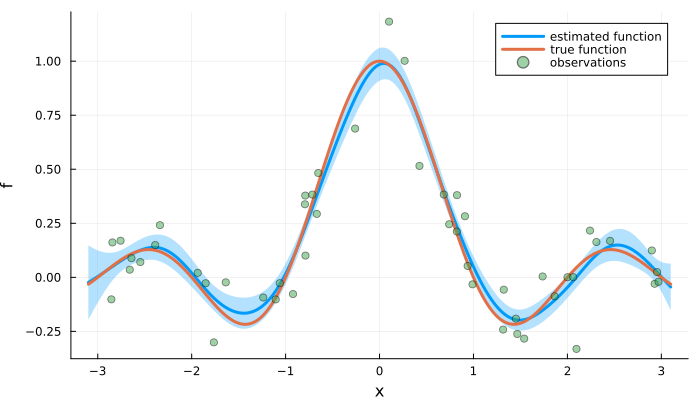

In [43]:
plot(xtest,mean(iresult.posteriors[:x][end].data.finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].data.finitemarginal))),linewidth=3.0,label="estimated function",fillalpha=0.3, size=(700,400))
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5, label="observations")
xlabel!("x")
ylabel!("f")

┌ Info: Saved animation to /Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/GPregression_CVI.gif
└ @ Plots /Users/nguyenhuuminhhoang/.julia/packages/Plots/QZRtR/src/animation.jl:156


Plots.AnimatedGif("/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/GPregression_CVI.gif")
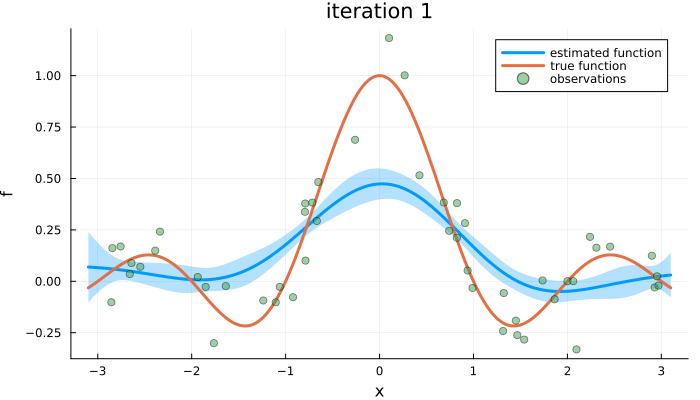

In [44]:
#create animation
anim = @animate for i=1:nits
    plot(xtest,mean(iresult.posteriors[:x][i].data.finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].data.finitemarginal))),linewidth=3.0,label="estimated function",fillalpha=0.3, size=(700,400), title="iteration $i")
    plot!(xtest,f_true,linewidth=3.0,label="true function")
    scatter!(xtrain,ytrain, alpha=0.5, label="observations")
    xlabel!("x")
    ylabel!("f")
end

gif(anim,"GPregression_CVI.gif",fps=2)

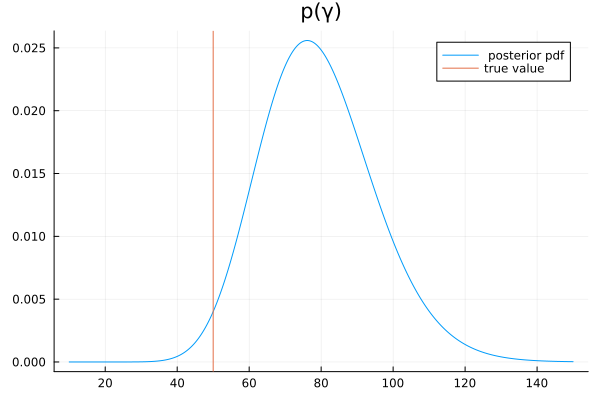

In [45]:
from  = 10
to    = 150
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="p(γ)",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)

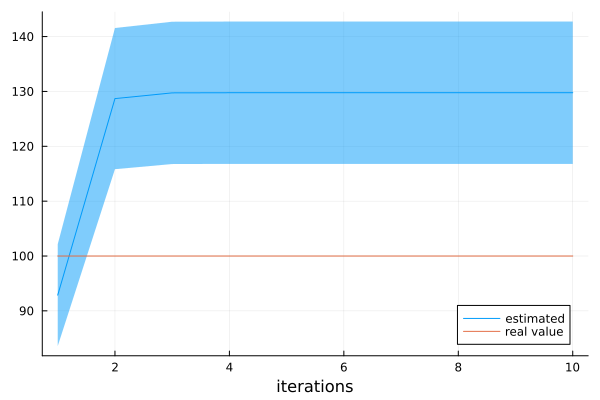

In [63]:
from = 1
to   = nits
plot(collect(from:to),mean.(iresult.posteriors[:γ])[from:to],ribbon=std.(iresult.posteriors[:γ])[from:to],label="estimated")
plot!(collect(from:to),precision*ones(to-from+1),label="real value")
xlabel!("iterations")

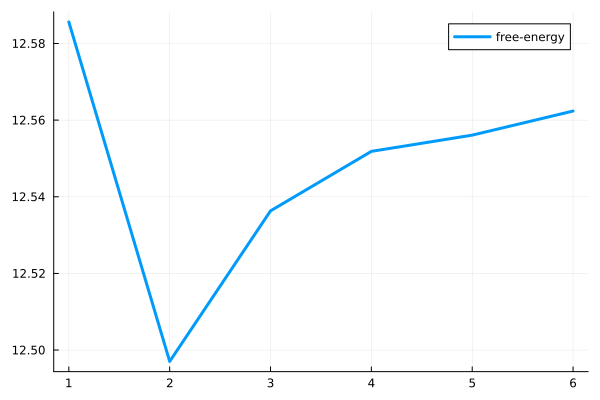

In [48]:
plot(log.(iresult.free_energy),linewidth=3.0,label="free-energy")

## EM 

In [5]:
# test new thing
@model function gp_regress(n,kernelfunc,meanfunc,train,test,log_θ,strategy)
    y = datavar(Float64,n)
    x = randomprocess(test,train, strategy)

    θ ~ NormalMeanVariance(log_θ_init, 10.)
    x ~ GaussianProcess(meanfunc,kernelfunc, θ) 
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i)}
    end
end

@constraints function gpconstraints()   
    q(θ) :: PointMass(starting_point = (args...) -> [ log_θ_init ])
    q(x,γ,θ) = q(x)q(γ)q(θ)
end

gpconstraints (generic function with 1 method)

In [6]:
nits = 5
iresult = inference(
    model = gp_regress(length(ytrain), k_func, meanfunc, xtrain,xtest,log_θ_init, cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01), θ = PointMass(log_θ_init)),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    free_energy = true,
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


Inference results:
  Posteriors       | available for (γ, θ, x)
  Free Energy:     | Real[6.33067e5, 7.12505e5, 6.92122e5, 6.83191e5, 6.76762e5]


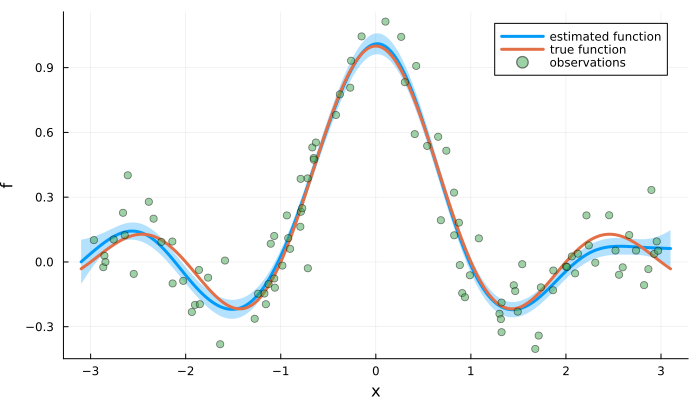

In [7]:
plot(xtest,mean(iresult.posteriors[:x][end].data.finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].data.finitemarginal))),linewidth=3.0,label="estimated function",fillalpha=0.3, size=(700,400))
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5, label="observations")
xlabel!("x")
ylabel!("f")

┌ Info: Saved animation to /Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/GPregression_EM.gif
└ @ Plots /Users/nguyenhuuminhhoang/.julia/packages/Plots/QZRtR/src/animation.jl:156


Plots.AnimatedGif("/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/GPregression_EM.gif")
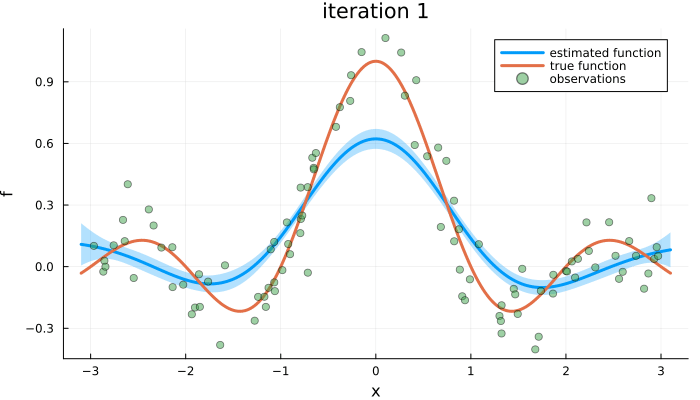

In [86]:
#create animation
anim = @animate for i=1:nits
    plot(xtest,mean(iresult.posteriors[:x][i].data.finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].data.finitemarginal))),linewidth=3.0,label="estimated function",fillalpha=0.3, size=(700,400), title="iteration $i")
    plot!(xtest,f_true,linewidth=3.0,label="true function")
    scatter!(xtrain,ytrain, alpha=0.5, label="observations")
    xlabel!("x")
    ylabel!("f")
end

gif(anim,"GPregression_EM.gif",fps=2)

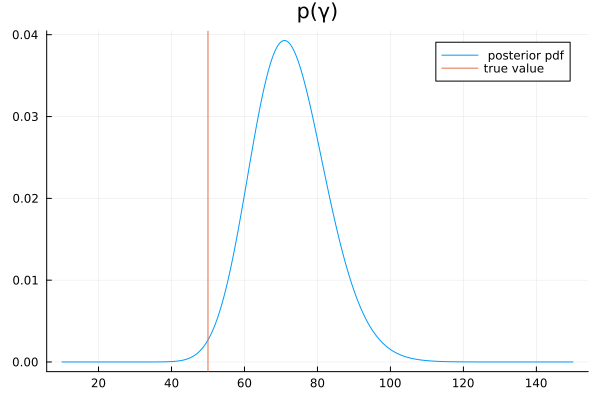

In [37]:
from  = 10
to    = 150
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="p(γ)",label=" posterior pdf")
vline!([precision],label="true value")

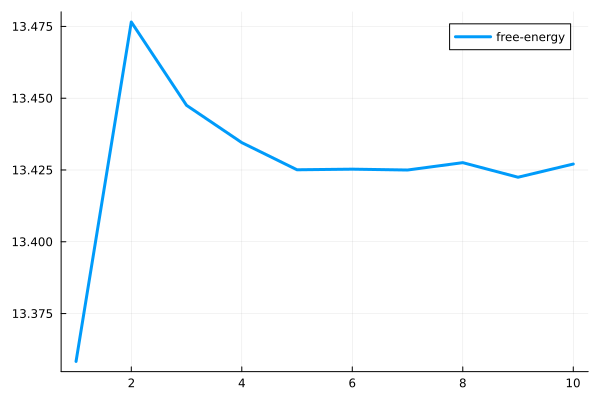

In [23]:
plot(log.(iresult.free_energy),linewidth=3.0,label="free-energy")

## Benchmark

In [8]:
@benchmark inference(
    model = gp_regress(length($ytrain), $k_func, $meanfunc, $xtrain,$xtest,$log_θ_init, $cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = gpconstraints(),
    iterations = $nits,  
    data  = (y = $ytrain,)
)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  896.903 ms …   1.081 s  ┊ GC (min … max): 1.39% … 1.43%
 Time  (median):     962.057 ms              ┊ GC (median):    1.15%
 Time  (mean ± σ):   974.041 ms ± 77.061 ms  ┊ GC (mean ± σ):  1.17% ± 0.47%

  ██        █                    █               █           █  
  ██▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  897 ms          Histogram: frequency by time          1.08 s <

 Memory estimate: 304.67 MiB, allocs estimate: 201518.

In [9]:
# BenchmarkTools.Trial: 2 samples with 1 evaluation.
#  Range (min … max):  3.252 s …    3.580 s  ┊ GC (min … max): 1.81% … 1.91%
#  Time  (median):     3.416 s               ┊ GC (median):    1.86%
#  Time  (mean ± σ):   3.416 s ± 231.910 ms  ┊ GC (mean ± σ):  1.86% ± 0.07%

#   █                                                        █  
#   █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
#   3.25 s         Histogram: frequency by time         3.58 s <

#  Memory estimate: 564.59 MiB, allocs estimate: 269693.

In [ ]:
# BenchmarkTools.Trial: 5 samples with 1 evaluation.
#  Range (min … max):  1.001 s …   1.065 s  ┊ GC (min … max): 1.29% … 1.20%
#  Time  (median):     1.019 s              ┊ GC (median):    1.09%
#  Time  (mean ± σ):   1.026 s ± 27.240 ms  ┊ GC (mean ± σ):  0.99% ± 0.29%

#   ██              █                  █                    █  
#   ██▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
#   1 s            Histogram: frequency by time        1.06 s <

#  Memory estimate: 304.67 MiB, allocs estimate: 201508.

In [1]:
#play with cache 
struct MyCache 
    cache_matrix::Dict{Tuple{Symbol, Tuple{Int,Int}},Matrix{Float64}}
end  

In [2]:
MyCache() = MyCache(Dict{Tuple{Symbol, Tuple{Int,Int}},Matrix{Float64}}())

MyCache

In [3]:
a = MyCache()
a.cache_matrix

Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}()

In [4]:
function getcache(cache::MyCache, label::Tuple{Symbol, Tuple{Int, Int}})
    get!(() -> Matrix{Float64}(undef, label[2]), cache.cache_matrix, label)
end

getcache (generic function with 1 method)

In [5]:
getcache(a, (:key1, (4,4)))

4×4 Matrix{Float64}:
 0.0           0.0           2.35538e-314  0.0
 2.33629e-314  2.33628e-314  0.0           2.33629e-314
 2.33627e-314  4.4e-323      2.33629e-314  2.33719e-314
 0.0           2.33629e-314  2.33627e-314  0.0

In [7]:
getcache(a, (:key5, (4,4)))

4×4 Matrix{Float64}:
 0.0           2.33629e-314  2.33627e-314  0.0
 2.33629e-314  2.33627e-314  0.0           2.33629e-314
 2.33629e-314  0.0           2.33629e-314  2.33702e-314
 0.0           2.33629e-314  2.33702e-314  0.0

In [9]:
a.cache_matrix

Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}} with 2 entries:
  (:key1, (4, 4)) => [0.0 0.0 2.35538e-314 0.0; 2.33629e-314 2.33628e-314 0.0 2…
  (:key5, (4, 4)) => [0.0 2.33629e-314 2.33627e-314 0.0; 2.33629e-314 2.33627e-…

In [19]:
#use get!(dictionary, key, default_value)
get!(a,:key2,5)

2

In [18]:
a

Dict{Symbol, Int64} with 3 entries:
  :key2 => 2
  :key6 => 5
  :key1 => 1

In [21]:
#use get!(function, dictionary, key)
f = (x) -> x + 2
f(2)

4

In [34]:
get!(() -> 2,a, :key1)

1

In [35]:
a

Dict{Symbol, Int64} with 4 entries:
  :key3 => 3
  :key2 => 2
  :key6 => 5
  :key1 => 1